# Importing Libararies

In [23]:
import os
import json as js
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import zipfile
import sklearn as sk
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


In [24]:
with open('kaggle.json') as f:
    data = js.load(f)
    username = data['username']
    keys = data['key']

os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = keys

# Check for zip file existence and content
path_to_zip_file = 'usa-real-estate-dataset.zip'
if not os.path.exists(path_to_zip_file) or os.path.getsize(path_to_zip_file) == 0:
    print('Zip file does not exist or is empty, so the file will be downloaded')
    os.system('kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset')
else:
    print('Zip file exists and is not empty, so it will be used directly\n')

df = None
with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
    list_name = zip_ref.namelist()
    print(type(list_name))
    print(list_name)
    
    try:
        first_csv = next(name for name in list_name if name.endswith('.csv'))
        with zip_ref.open(first_csv) as zipfile:
            df = pd.read_csv(zipfile)
        
        rows, columns = df.shape
        print("Rows: ", rows, '\nColumns: ', columns)
        
    except StopIteration:
        print("No CSV files found in the archive. The zip file might be empty or corrupt.")
        os.remove(first_csv)
        print("Attempting to re-download the dataset after deleting the old one...")

        os.system('kaggle datasets download -d ahmedshahriarsakib/usa-real-estate-dataset')

if df is None:
    print("Failed to load the dataset. Please check your internet connection and try again.")

df.head()

Zip file exists and is not empty, so it will be used directly

<class 'list'>
['realtor-data.zip.csv']
Rows:  2226382 
Columns:  12


,brokered_by,status,price,bed,bath,acre_lot,street,city,state,zip_code,house_size,prev_sold_date
0,103378.0,for_sale,105000.0,3.0,2.0,0.12,1962661.0,Adjuntas,Puerto Rico,601.0,920.0,NaN
1,52707.0,for_sale,80000.0,4.0,2.0,0.08,1902874.0,Adjuntas,Puerto Rico,601.0,1527.0,NaN
2,103379.0,for_sale,67000.0,2.0,1.0,0.15,1404990.0,Juana Diaz,Puerto Rico,795.0,748.0,NaN
3,31239.0,for_sale,145000.0,4.0,2.0,0.10,1947675.0,Ponce,Puerto Rico,731.0,1800.0,NaN
4,34632.0,for_sale,65000.0,6.0,2.0,0.05,331151.0,Mayaguez,Puerto Rico,680.0,NaN,NaN


In [25]:
df_training_sets = df[['acre_lot', 'bed', 'bath', 'city', 'state', 'house_size', 'price']]
df_training_sets

,acre_lot,bed,bath,city,state,house_size,price
0,0.12,3.0,2.0,Adjuntas,Puerto Rico,920.0,105000.0
1,0.08,4.0,2.0,Adjuntas,Puerto Rico,1527.0,80000.0
2,0.15,2.0,1.0,Juana Diaz,Puerto Rico,748.0,67000.0
3,0.10,4.0,2.0,Ponce,Puerto Rico,1800.0,145000.0
4,0.05,6.0,2.0,Mayaguez,Puerto Rico,NaN,65000.0
...,...,...,...,...,...,...,...
2226377,0.33,4.0,2.0,Richland,Washington,3600.0,359900.0
2226378,0.10,3.0,2.0,Richland,Washington,1616.0,350000.0
2226379,0.50,6.0,3.0,Richland,Washington,3200.0,440000.0
2226380,0.09,2.0,1.0,Richland,Washington,933.0,179900.0


In [26]:
null_sum = df_training_sets.isnull().sum();
print('-------Null sums------\n',null_sum,'\n\n\n-------Data types------');
data_types = df_training_sets.dtypes;
print(data_types);


-------Null sums------
 acre_lot      325589
bed           481317
bath          511771
city            1407
state              8
house_size    568484
price           1541
dtype: int64 


-------Data types------
acre_lot      float64
bed           float64
bath          float64
city           object
state          object
house_size    float64
price         float64
dtype: object


In [27]:
# Copy the dataframe
df_clean = df_training_sets.copy()

# Define numeric and categorical columns
numeric_cols = ['acre_lot', 'bed', 'bath', 'house_size', 'price']
categorical_cols = ['city', 'state']

for col in numeric_cols:
    df_clean[col] = df_clean[col].fillna(df_clean[col].median())

SP = SimpleImputer(missing_values=np.nan, strategy='most_frequent')

# For categorical columns, fit and transform the data
for col in categorical_cols:
    df_clean[col] = SP.fit_transform(df_clean[[col]]).ravel()

print(df_clean.head())

SC = StandardScaler();

df_clean[numeric_cols] = SC.fit_transform(df_clean[numeric_cols])


   acre_lot  bed  bath        city        state  house_size     price
0      0.12  3.0   2.0    Adjuntas  Puerto Rico       920.0  105000.0
1      0.08  4.0   2.0    Adjuntas  Puerto Rico      1527.0   80000.0
2      0.15  2.0   1.0  Juana Diaz  Puerto Rico       748.0   67000.0
3      0.10  4.0   2.0       Ponce  Puerto Rico      1800.0  145000.0
4      0.05  6.0   2.0    Mayaguez  Puerto Rico      1760.0   65000.0


In [28]:

# Initialize LabelEncoder for city and state
label_encoder = LabelEncoder()

# Encode city and state columns with integer values
df_clean['city_encoded'] = label_encoder.fit_transform(df_clean['city'])
df_clean['state_encoded'] = label_encoder.fit_transform(df_clean['state'])

# Drop the original city and state columns if needed
df_clean.drop(columns=['city', 'state'], inplace=True)

print(df_clean.head())

   acre_lot       bed      bath  house_size     price  city_encoded  \
0 -0.018322 -0.155300 -0.260934   -0.002224 -0.195990            92   
1 -0.018379  0.562991 -0.260934   -0.001353 -0.207682            92   
2 -0.018280 -0.873590 -0.943427   -0.002470 -0.213762          8788   
3 -0.018351  0.562991 -0.260934   -0.000962 -0.177282         14314   
4 -0.018422  1.999571 -0.260934   -0.001019 -0.214698         10936   

   state_encoded  
0             41  
1             41  
2             41  
3             41  
4             41  


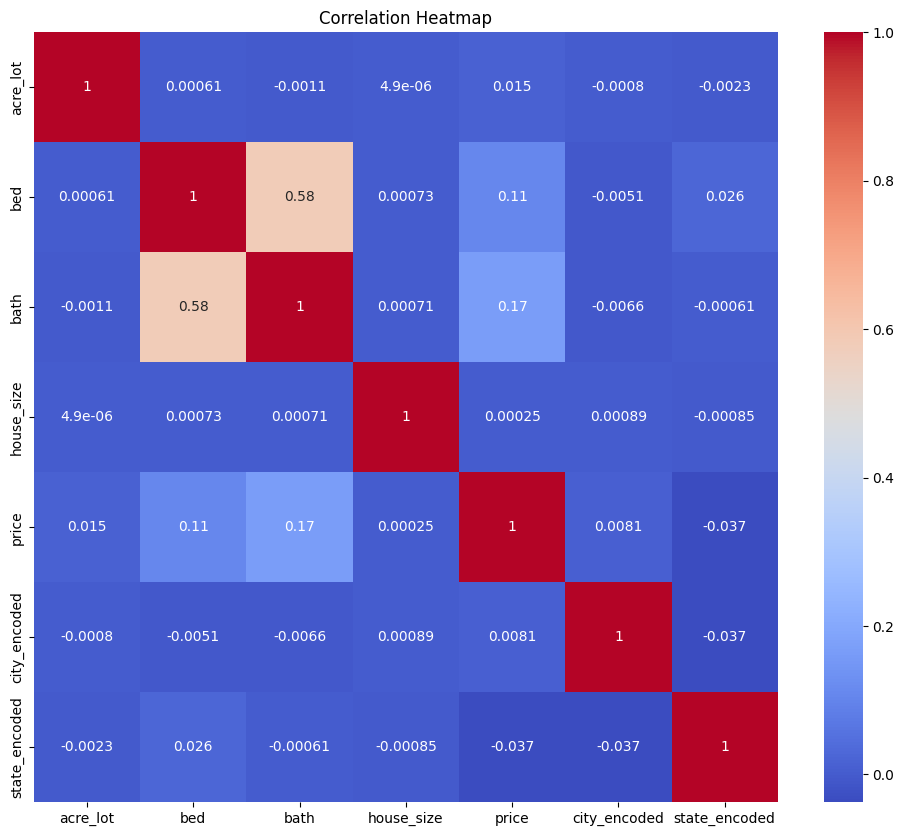

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(df_clean.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()